# Compute Coverage

This example demonstrates how to use direct function calls of the low-level TAT-C library to perform coverage analysis over a region of interest.

Similar to the _Collect Observations_ example, the first steps are to define the satellites for the mission. This example again uses the NOAA-20 satellite with a two-line elements model from July 2022 and a VIIRS instrument with field of regard computed based on a 834km altitude and 3000km swath width.

In [1]:
from tatc import utils
from tatc.schemas import Instrument, Satellite, TwoLineElements

viirs = Instrument(
    name="VIIRS",
    field_of_regard=utils.swath_width_to_field_of_regard(834000, 3000000),
)
noaa20 = Satellite(
    name="NOAA 20",
    orbit=TwoLineElements(
        tle=[
            "1 43013U 17073A   22195.78278435  .00000038  00000+0  38919-4 0  9996",
            "2 43013  98.7169 133.9110 0001202  63.8768 296.2532 14.19561306241107",
        ]
    ),
    instruments=[viirs],
)

The mission considers a 30-day integration period starting at noon UTC on July 14, 2022.

In [2]:
from datetime import datetime, timedelta, timezone

start = datetime(year=2022, month=7, day=14, hour=12, tzinfo=timezone.utc)
end = start + timedelta(days=30)

Coverage analyses typically compute metrics over a spatial region. The `generate_equally_spaced_points` method in TAT-C distributes sample points over a uniform latitude-longitude grid, scaled based on a characteristic distance, set to 5000 km in this example.

In [3]:
from tatc.generation import generate_equally_spaced_points

points_df = generate_equally_spaced_points(5000e3)
display(points_df)

,point_id,geometry
0,0,POINT Z (-157.51699 -67.51699 0.00000)
1,1,POINT Z (-112.55097 -67.51699 0.00000)
2,2,POINT Z (-67.58495 -67.51699 0.00000)
3,3,POINT Z (-22.61894 -67.51699 0.00000)
4,4,POINT Z (22.34708 -67.51699 0.00000)
5,5,POINT Z (67.31310 -67.51699 0.00000)
6,6,POINT Z (112.27912 -67.51699 0.00000)
7,7,POINT Z (157.24514 -67.51699 0.00000)
8,8,POINT Z (-157.51699 -22.55097 0.00000)
9,9,POINT Z (-112.55097 -22.55097 0.00000)


The resulting 32 points are distributed over the globe.

(-90.0, 90.0)

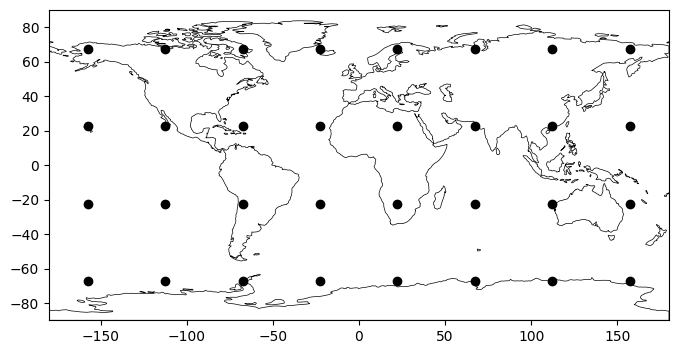

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd

# load a shapefile containing land from https://www.naturalearthdata.com/downloads/110m-physical-vectors/
worldmap = gpd.read_file("ne_110m_land.zip")

fig, ax = plt.subplots(figsize=(8, 5))

points_df.plot(color="k", ax=ax)
worldmap.boundary.plot(ax=ax, color="black", lw=0.5)
plt.xlim([-180, 180])
plt.ylim((-90, 90))

As the TAT-C analysis functions require points specified in the TAT-C format, rather than a data frame, it is often convenient to convert and store the points in a separate list.

In [5]:
from tatc.schemas import Point

points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

The `collect_observations` method can be called either using sequential or parallel computation (using `joblib`). While there is some overhead associated with parallel computation, it is usually faster on modern multi-core machines.

In [6]:
from tatc.analysis import collect_observations

import time

t = time.time()
results_list = [
    collect_observations(point, noaa20, viirs, start, end) for point in points
]
print(f"Sequential computation completed in {time.time() - t:.2f} seconds")

Sequential computation completed in 8.59 seconds


In [7]:
from tatc.analysis import collect_observations

import time
from joblib import Parallel, delayed

t = time.time()
results_list = Parallel(n_jobs=-1)(
    delayed(collect_observations)(point, noaa20, viirs, start, end) for point in points
)
print(f"Parallel computation completed in {time.time() - t:.2f} seconds")

Parallel computation completed in 2.78 seconds


Next, we concatenate the results into a single data frame.

In [8]:
import pandas as pd

results = pd.concat(results_list, ignore_index=True)
display(results)

,point_id,geometry,satellite,instrument,start,end,epoch,sat_alt,sat_az
0,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-14 23:30:13.504937+00:00,2022-07-14 23:35:24.700151+00:00,2022-07-14 23:32:49.102544+00:00,30.035465,90.531924
1,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-15 01:09:57.221103+00:00,2022-07-15 01:17:36.070193+00:00,2022-07-15 01:13:46.645648+00:00,84.027569,71.175306
2,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-15 02:50:32.021280+00:00,2022-07-15 02:56:59.202403+00:00,2022-07-15 02:53:45.611841500+00:00,41.004461,223.803001
3,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-15 04:31:23.154019+00:00,2022-07-15 04:34:35.637143+00:00,2022-07-15 04:32:59.395581+00:00,23.798761,200.198374
4,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-15 07:48:30.230323+00:00,2022-07-15 07:52:58.807543+00:00,2022-07-15 07:50:44.518933+00:00,27.400165,151.773200
...,...,...,...,...,...,...,...,...,...
4782,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-12 18:28:49.325939+00:00,2022-08-12 18:34:03.183661+00:00,2022-08-12 18:31:26.254800+00:00,31.260724,324.671047
4783,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-12 21:48:42.817756+00:00,2022-08-12 21:49:48.545180+00:00,2022-08-12 21:49:15.681468+00:00,21.116313,13.096062
4784,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-12 23:25:35.417650+00:00,2022-08-12 23:31:03.448822+00:00,2022-08-12 23:28:19.433236+00:00,32.782539,37.025943
4785,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-13 01:04:19.959524+00:00,2022-08-13 01:11:46.499770+00:00,2022-08-13 01:08:03.229647+00:00,73.846900,59.291643


The `aggregate_observations` function computes the access and revisit statistics for each point.

In [9]:
from tatc.analysis import aggregate_observations

aggregated_results = aggregate_observations(results)
display(aggregated_results)

,geometry,point_id,satellite,instrument,start,epoch,end,access,revisit
0,POINT Z (-157.51699 -67.51699 0.00000),0,NOAA 20,VIIRS,2022-07-14 23:30:13.504937+00:00,2022-07-14 23:32:49.102543872+00:00,2022-07-14 23:35:24.700151+00:00,0 days 00:05:11.195214,NaT
1,POINT Z (-157.51699 -67.51699 0.00000),0,NOAA 20,VIIRS,2022-07-15 01:09:57.221103+00:00,2022-07-15 01:13:46.645647872+00:00,2022-07-15 01:17:36.070193+00:00,0 days 00:07:38.849090,0 days 01:34:32.520952
2,POINT Z (-157.51699 -67.51699 0.00000),0,NOAA 20,VIIRS,2022-07-15 02:50:32.021280+00:00,2022-07-15 02:53:45.611841536+00:00,2022-07-15 02:56:59.202403+00:00,0 days 00:06:27.181123,0 days 01:32:55.951087
3,POINT Z (-157.51699 -67.51699 0.00000),0,NOAA 20,VIIRS,2022-07-15 04:31:23.154019+00:00,2022-07-15 04:32:59.395580928+00:00,2022-07-15 04:34:35.637143+00:00,0 days 00:03:12.483124,0 days 01:34:23.951616
4,POINT Z (-157.51699 -67.51699 0.00000),0,NOAA 20,VIIRS,2022-07-15 07:48:30.230323+00:00,2022-07-15 07:50:44.518932992+00:00,2022-07-15 07:52:58.807543+00:00,0 days 00:04:28.577220,0 days 03:13:54.593180
...,...,...,...,...,...,...,...,...,...
4782,POINT Z (157.24514 67.38106 0.00000),31,NOAA 20,VIIRS,2022-08-12 18:28:49.325939+00:00,2022-08-12 18:31:26.254799872+00:00,2022-08-12 18:34:03.183661+00:00,0 days 00:05:13.857722,0 days 01:33:21.770501
4783,POINT Z (157.24514 67.38106 0.00000),31,NOAA 20,VIIRS,2022-08-12 21:48:42.817756+00:00,2022-08-12 21:49:15.681467904+00:00,2022-08-12 21:49:48.545180+00:00,0 days 00:01:05.727424,0 days 03:14:39.634095
4784,POINT Z (157.24514 67.38106 0.00000),31,NOAA 20,VIIRS,2022-08-12 23:25:35.417650+00:00,2022-08-12 23:28:19.433235968+00:00,2022-08-12 23:31:03.448822+00:00,0 days 00:05:28.031172,0 days 01:35:46.872470
4785,POINT Z (157.24514 67.38106 0.00000),31,NOAA 20,VIIRS,2022-08-13 01:04:19.959524+00:00,2022-08-13 01:08:03.229647104+00:00,2022-08-13 01:11:46.499770+00:00,0 days 00:07:26.540246,0 days 01:33:16.510702


The `reduce_observations` function computes descriptive statistics for each point.

In [10]:
from tatc.analysis import reduce_observations

reduced_results = reduce_observations(aggregated_results)
display(reduced_results)

,point_id,geometry,access,revisit,samples
0,0,POINT Z (-157.51699 -67.51699 0.00000),0 days 00:05:28.706252,0 days 02:56:33.402040,234
1,1,POINT Z (-112.55097 -67.51699 0.00000),0 days 00:05:27.188000,0 days 02:55:27.373902,236
2,2,POINT Z (-67.58495 -67.51699 0.00000),0 days 00:05:28.226553,0 days 02:55:47.325765,235
3,3,POINT Z (-22.61894 -67.51699 0.00000),0 days 00:05:28.704311,0 days 02:56:12.254292,235
4,4,POINT Z (22.34708 -67.51699 0.00000),0 days 00:05:29.870004,0 days 02:57:19.323572,233
5,5,POINT Z (67.31310 -67.51699 0.00000),0 days 00:05:26.640496,0 days 02:57:41.790669,236
6,6,POINT Z (112.27912 -67.51699 0.00000),0 days 00:05:29.212610,0 days 02:58:25.810793,235
7,7,POINT Z (157.24514 -67.51699 0.00000),0 days 00:05:29.090271,0 days 02:59:13.645473,234
8,8,POINT Z (-157.51699 -22.55097 0.00000),0 days 00:05:48.302767,0 days 09:52:38.682242,72
9,9,POINT Z (-112.55097 -22.55097 0.00000),0 days 00:05:52.740981,0 days 10:01:06.238332,71


Finally, we can visualize results, first converting metrics to numeric formats.

(-90.0, 90.0)

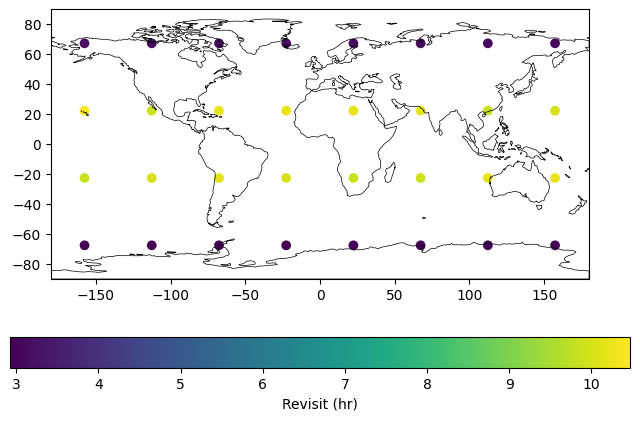

In [11]:
import matplotlib.pyplot as plt

reduced_results["revisit_hr"] = reduced_results.revisit / timedelta(hours=1)

fig, ax = plt.subplots(figsize=(8, 5))
reduced_results.plot(
    column="revisit_hr",
    cmap="viridis",
    legend=True,
    legend_kwds={"label": "Revisit (hr)", "orientation": "horizontal"},
    ax=ax,
)
worldmap.boundary.plot(ax=ax, color="black", lw=0.5)
plt.xlim([-180, 180])
plt.ylim((-90, 90))

Coverage analyses can also be aggregated to spatial regions for improved visualizations. This example focuses on a smaller spatial region covering the Continental United States (CONUS) defined by a Polygon. Similar to how the `generate_equally_spaced_points` generates uniformly-distributed points (in latitude/longitude), the function `generate_equally_spaced_cells` generates uniformly distributed cells. This example uses twice the characteristic distance (1000 km vs. 500 km) such that each cell covers about four points.

,cell_id,geometry
0,486,"POLYGON Z ((-125.00000 19.00000 0.00000, -125...."
1,488,"POLYGON Z ((-108.05437 19.00000 0.00000, -108...."
2,487,"POLYGON Z ((-117.04757 19.00000 0.00000, -117...."
3,526,"POLYGON Z ((-125.00000 26.91165 0.00000, -125...."
4,528,"POLYGON Z ((-108.05437 26.91165 0.00000, -108...."
5,527,"POLYGON Z ((-117.04757 26.91165 0.00000, -117...."
6,567,"POLYGON Z ((-117.04757 35.90485 0.00000, -117...."
7,566,"POLYGON Z ((-125.00000 35.90485 0.00000, -125...."
8,568,"POLYGON Z ((-108.05437 35.90485 0.00000, -108...."
9,569,"POLYGON Z ((-99.06117 35.90485 0.00000, -99.06..."


<Axes: >

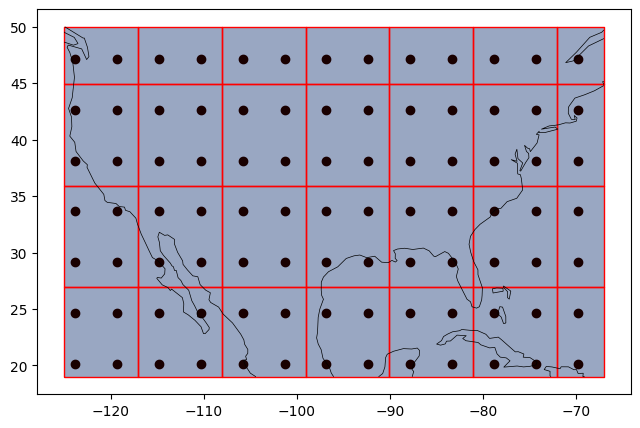

In [12]:
from shapely.geometry import Polygon

target = Polygon([(-125, 50), (-67, 50), (-67, 19), (-125, 19), (-125, 50)])

import geopandas as gpd

target_area = gpd.GeoDataFrame({"geometry": target}, index=[0], crs="EPSG:4326")

from tatc.generation.points import generate_equally_spaced_points
from tatc.generation.cells import generate_equally_spaced_cells

points_df = generate_equally_spaced_points(500e3, mask=target)
cells_df = generate_equally_spaced_cells(1000e3, mask=target)

display(cells_df)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
target_area.plot(alpha=0.5, ax=ax)
points_df.plot(color="k", ax=ax)
cells_df.plot(edgecolor="r", facecolor=(1, 0, 0, 0.1), ax=ax)
worldmap.boundary.clip(cells_df).plot(ax=ax, color="black", lw=0.5)

Similar to the prior case, coverage analysis can be performed for each point.

<Axes: >

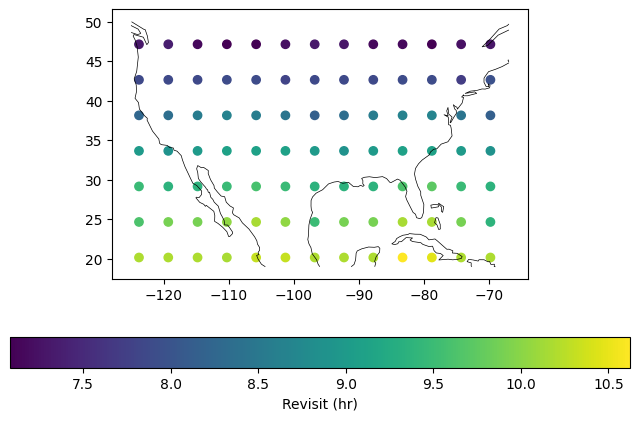

In [13]:
from tatc.schemas import Point

points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

from joblib import Parallel, delayed
from tatc.analysis.coverage import collect_observations

results_list = Parallel(n_jobs=-1)(
    delayed(collect_observations)(point, noaa20, viirs, start, end) for point in points
)
results = pd.concat(results_list, ignore_index=True)

from tatc.analysis import aggregate_observations

aggregated_results = aggregate_observations(results)

from tatc.analysis.coverage import reduce_observations

reduced_results = reduce_observations(aggregated_results)

reduced_results["revisit_hr"] = reduced_results.apply(
    lambda r: r["revisit"] / timedelta(hours=1), axis=1
)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
reduced_results.plot(
    column="revisit_hr",
    cmap="viridis",
    legend=True,
    legend_kwds={"label": "Revisit (hr)", "orientation": "horizontal"},
    ax=ax,
)
worldmap.boundary.clip(cells_df).plot(ax=ax, color="black", lw=0.5)

In addition, the results can be merged into the cell specification using a spatial join and dissolve operation. Note that, when working on the reduced results, the revisit aggregation function must perform a weighted average based on the number of samples for each point.

<Axes: >

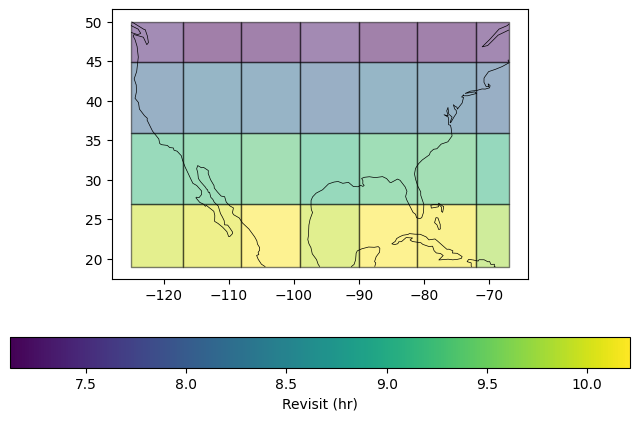

In [14]:
import numpy as np

grid_results = (
    cells_df.sjoin(reduced_results, how="inner", predicate="contains")
    .dissolve(
        by="cell_id",
        aggfunc={
            "samples": "sum",
            "revisit_hr": lambda r: np.average(
                r, weights=reduced_results.loc[r.index, "samples"]
            ),
        },
    )
    .reset_index()
)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
grid_results.plot(
    column="revisit_hr",
    cmap="viridis",
    edgecolor="k",
    alpha=0.5,
    legend=True,
    legend_kwds={"label": "Revisit (hr)", "orientation": "horizontal"},
    ax=ax,
)
worldmap.boundary.clip(cells_df).plot(ax=ax, color="black", lw=0.5)